In [1]:
from h5glance import H5Glance
import h5py

In [3]:
SIM = h5py.File("/user/vitaldehenau/Github/pyMGMR3D/run/SIM000001.hdf5")
H5Glance(SIM)

/user/vitaldehenau/Github/pyMGMR3D/run/SIM000001.hdf5/
├atmosphere	(3 children)
├inputs	(0 children) (32 attributes)
└observers	(632 children)

In [4]:
print(list(SIM["/inputs"].attrs))

print(" ")
print(list(SIM["/observers/pos_010_045"].attrs))
print((SIM["/observers/pos_010_045"].attrs["columns"]))
print((SIM["/observers/pos_010_045"].attrs["units"]))

print(" ")
print(list(SIM["/atmosphere/Currents"].attrs))
print(list(SIM["/atmosphere/Currents"].attrs["columns"]))
print(list(SIM["/atmosphere/Force"].attrs["columns"]))
print(list(SIM["/atmosphere/Geometry"].attrs["columns"]))


['AlternativeSmooth', 'Azi_sh', 'D_ESmooth', 'ENERGY_SH2', 'F_lim', 'Fit_StI', 'GROUNDLEVEL', 'IntegrateCurrent', 'Intensity_Weight', 'Intensity_weight', 'J0Q', 'J0T', 'MOLIERERADIUS', 'ObsDist_dim', 'OutFileLabel', 'RnrmA', 'RnrmB', 'SAMPLINGTIME', 'StParRange', 'X_02', 'X_MAX2', 'X_max', 'Zen_sh', 'azi_B', 'energy_sh', 'lamx', 'lamx2', 'nu_max', 'nu_min', 'u0', 'x_0', 'zen_B']
 
['columns', 'position', 'units']
[b't_us' b'Re_Ex' b'Im_Ex' b'Re_Ey' b'Im_Ey' b'Ex' b'Ey' b'Ez']
[b'us' b'V/m' b'V/m' b'V/m' b'V/m' b'V/m' b'V/m' b'V/m']
 
['columns']
[b'Ix', b'Iy', b'charge_excess', b'dxi']
[b'Fx', b'Fy', b'F_mag_keVpm', b'phi']
[b'z_km', b'X_gcm2', b'refractivity', b'alpha_tr']


In [5]:
import matplotlib.cm as cm
from matplotlib import cycler

import cr_pulse_interpolator.signal_interpolation_fourier as signal_fourier
import cr_pulse_interpolator.interpolation_fourier as interp_fourier
import radiotools.atmosphere.cherenkov_radius as cr
from radiotools.atmosphere import models as atm
import radiotools.atmosphere.models as mo
import radiotools.coordinatesystems as cs
from radiotools import coordinatesystems
import radiotools.helper as hp

conversion_fieldstrength_cgs_to_SI = 2.99792458e10*1e-6
speed_of_light_times_epsilon_0_SI = 2.99792458e8*8.8541878188e-12 #m/s * J/V**2 1/m -> J/s 1/V**2
conversion_factor_Joule_to_eV = 6.24150934e18 # J/m**2 -> eV/m**2

#["t_us", "Re_Ex", "Im_Ex", "Re_Ey", "Im_Ey", "Ex", "Ey", "Ez"]

def observer_to_si_geomagnetic(observer):

    data = np.copy(observer)
    data[:, 5], data[:, 6] = -observer[:, 6], observer[:, 5]
    data[:, 5:] *= conversion_fieldstrength_cgs_to_SI
    
    return data


def filter_trace(trace, low_freq, high_freq, sampling_period, axis=1):

    freq = np.fft.rfftfreq(trace.shape[axis], d=sampling_period)
    freq_mask = np.logical_or(freq <= low_freq * 1e6, freq >= high_freq * 1e6)

    fft = np.fft.rfft(trace, axis=axis)
    fft[:, freq_mask] *= 0.0  # does not work nicely with axis argument

    return np.fft.irfft(fft, axis=axis)


def get_pos_and_signals(sim):

    # Read in the simulation file
    reader = h5py.File(sim)
    
    sampling_period = reader["inputs"].attrs["SAMPLINGTIME"]

    # Make coordinate transformation object
    zenith = np.deg2rad(reader['inputs'].attrs["Zen_sh"])
    azimuth = hp.get_normalized_angle(3 * np.pi / 2. + np.deg2rad(reader['inputs'].attrs["Azi_sh"]))
    By, minBz = 18.6, 45.6
    transformer = cs.cstrafo(zenith, azimuth, magnetic_field_vector=np.array([0, By, -1 * minBz]))

    # Transform the antenna positions to shower plane
    pos_ground = []
    signals_on_sky = []
    signals_start_time = []
    for observer in reader['observers'].values():
        
        obs_pos_ground = observer.attrs['position']
        pos_ground.append([-1 * obs_pos_ground[1], obs_pos_ground[0], 760])
        signal = observer_to_si_geomagnetic(observer)
        signals_start_time.append(signal[0, 0])
        signal_ground = transformer.transform_from_magnetic_to_geographic(signal[:,5:].T)
        signal_on_sky = transformer.transform_from_ground_to_onsky(signal_ground)

        signals_on_sky.append(signal_on_sky.T)

    pos_ground = np.asarray(pos_ground)
    signals_on_sky = np.asarray(signals_on_sky)

    pos_showerplane = transformer.transform_to_vxB_vxvxB(pos_ground, core=np.array([0, 0, 760]))
    pos_showerplane /= 100  # convert to m

    reader.close()
    
    return pos_showerplane, signals_on_sky, signals_start_time, sampling_period


def get_fluence_interpolator(sim, low, high):

    pos_showerplane, signals, signals_start_time, signals_sampling_period = get_pos_and_signals(sim)
    fluence_in_band = np.sum(filter_trace(signals, low, high, signals_sampling_period) ** 2, axis=(1, 2)) #(V/m)**2
    fluence_in_band *= speed_of_light_times_epsilon_0_SI*signals_sampling_period # (V/m)**2 * J/s 1/V**2 * s =  J/m**2
    fluence_in_band *= conversion_factor_Joule_to_eV #J/m**2 -> eV/m**2

    # Make the interpolator
    fluence_interpolator = interp_fourier.interp2d_fourier(
        np.round(pos_showerplane[:, 0], 4),
        np.round(pos_showerplane[:, 1], 4),
        fluence_in_band,
        fill_value="extrapolate"
    )
    return fluence_in_band, fluence_interpolator

In [6]:
#import NuRadioReco.utilities.fft as fft_u
#from double_bump_plots import *
import matplotlib.pyplot as pl
import numpy as np
#import sys
#import os

#from Radio import *

conversion_fieldstrength_cgs_to_SI = 2.99792458e10*1e-6

def plot_antenna_positions(sim):
    
    fig = pl.figure(figsize=(5,5))
    pl.grid()

    x, y, P_total = np.array([]), np.array([]), np.array([])

    for pos in sim["/observers"]:
        position = sim[f"/observers/{pos}"].attrs["position"]
        E = np.array((sim[f"/observers/{pos}"][:, 1:5]).T) #GV/m
        E = filter_trace(E, 300, 350, sim["inputs"].attrs["SAMPLINGTIME"]) #ns
        x, y, P_total  = np.append(x, position[0]), np.append(y, position[1]), np.append(P_total, np.sqrt(np.sum(E**2)))

    sc = pl.scatter(x, y, c=P_total, s=10, cmap="viridis")
    pl.colorbar(sc, label="Power")
    pl.xlabel("North [cm]")
    pl.ylabel("West [cm]")
    pl.show()

def plot_traces_of_antennas(sim, positions):

    num_positions = len(positions)
    cols = min(5, num_positions)
    rows = (num_positions + cols - 1) // cols

    fig, axes = pl.subplots(rows, cols, figsize=(4 * cols, 5 * rows), sharey=True)

    if rows > 1:
        axes = axes.flatten()
    else:
        axes = np.array(axes).flatten()

    for i, pos in enumerate(positions):
        t = sim[f"/observers/{pos}"][:, 0]
        E = sim[f"/observers/{pos}"][:, 1:5].T#*conversion_fieldstrength_cgs_to_SI*1e6 #μV/m
        #E = filter_trace(E, 300, 350, sim["inputs"].attrs["SAMPLINGTIME"]) #MHz filter
        ax = axes[i]
        ax.grid()
        ax.plot(t, E[0], label="E_x")
        ax.plot(t, E[2], label="E_y")
        ax.set_xlabel("Time [ns]")
        if i % cols == 0:
            ax.set_ylabel("E-field [GV/m]") #μV/m
        ax.set_title(f"Observer: {pos}")
        ax.legend()

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    pl.show()
    

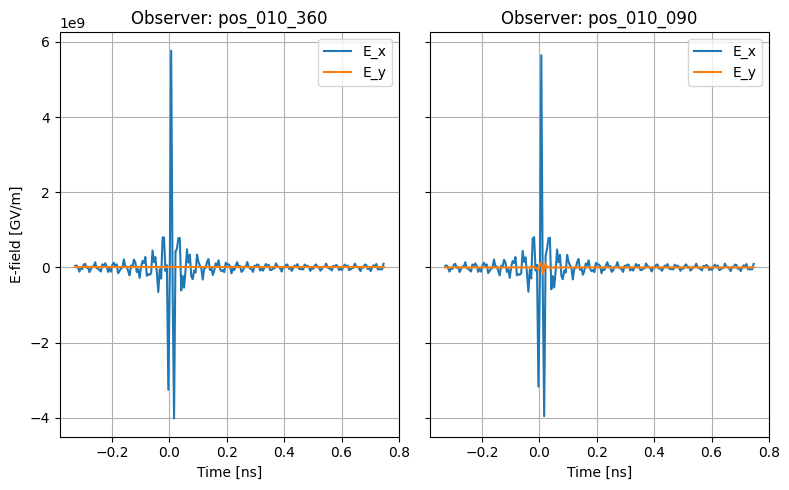

In [7]:
plot_traces_of_antennas(SIM,["pos_010_360", "pos_010_090"])

#plot_traces_of_antennas(SIM,["pos_100_360", "pos_100_090"])

#plot_traces_of_antennas(SIM,["pos_250_360", "pos_250_090"])


In [ ]:
plot_antenna_positions(SIM)

In [ ]:
def plot_fluence_grid(sim, filters, color_bar_share=True):
    
    dist_scale = 400.0
    ti = np.linspace(-dist_scale, dist_scale, 1000)
    XI, YI = np.meshgrid(ti, ti)

    fig, axs = pl.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
    axs = axs.flatten()

    ims = []
    max_color_bar = None

    if color_bar_share:
        
        max_vals = []
        for low, high in filters:
            _, fluence_interp = get_fluence_interpolator(sim, low, high)
            Z = fluence_interp(XI, YI)
            max_vals.append(np.max(Z))
        max_color_bar = max(max_vals)

    for i, (low, high) in enumerate(filters):
        _, fluence_interp = get_fluence_interpolator(sim, low, high)
        ZI = fluence_interp(XI, YI)
        print(ZI)

        ax = axs[i]
        im = ax.pcolor(XI, YI, ZI, vmin=0, vmax=max_color_bar if color_bar_share else None, cmap=cm.jet)
        ims.append(im)

        ax.set_title(f'Fluence {low}-{high} MHz (Shower Plane)')
        ax.set_xlabel('vxB [m]')
        ax.set_ylabel('vxvxB [m]')
        ax.set_xlim(-dist_scale, dist_scale)
        ax.set_ylim(-dist_scale, dist_scale)
        ax.set_aspect('equal')

        if not color_bar_share:
            cbar = fig.colorbar(im, ax=ax)
            cbar.set_label('Radio energy fluence [eV/m$^2$]')

    if color_bar_share:
        cbar = fig.colorbar(ims[0], ax=axs, orientation='vertical', shrink=0.9, pad=0.02)
        cbar.set_label('Radio energy fluence [eV/m$^2$]')

    pl.show()

sim = "/user/vitaldehenau/Github/pyMGMR3D/run/SIM000001.hdf5"
filters = [[30, 80], [50, 350], [200, 250], [300, 350]]
plot_fluence_grid(sim, filters, color_bar_share=False)


In [ ]:
X =  np.linspace(0, 2000)

def Gaisser_Hillas_function(X, N_max, X_max, lamda, X_0): 
 
    if N_max is None:
        return None
        
    power =  ((X_max - X_0)/(lamda))
    
    X = np.where(X < X_0, X_0, X)
    
    N = N_max * ((X - X_0)/(X_max - X_0)) ** (power) * np.exp((X_max - X)/(lamda))
    N[(power < 0)] = 0
    N = np.nan_to_num(N)
    
    return N

N_max_1, X_max_1, lamda_1, X_0_1 = SIM["/inputs"].attrs["energy_sh"], SIM["/inputs"].attrs["X_max"], SIM["/inputs"].attrs["lamx"], SIM["/inputs"].attrs["x_0"]
N_max_2, X_max_2, lamda_2, X_0_2 = SIM["/inputs"].attrs["ENERGY_SH2"], SIM["/inputs"].attrs["X_MAX2"], SIM["/inputs"].attrs["lamx2"], SIM["/inputs"].attrs["X_02"]

Y_1 = Gaisser_Hillas_function(X, N_max_1, X_max_1, lamda_1, X_0_1)
Y_2 = Gaisser_Hillas_function(X, N_max_2, X_max_2, lamda_2, X_0_2)

pl.plot(X,Y_1)
pl.plot(X,Y_2)
pl.plot(X,Y_1+Y_2)
pl.show()
